## NLP: Sentiment Classification

In [ ]:
# Importing required libraries;

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, SpatialDropout1D, LSTM

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Reading the dataset

df = pd.read_csv("../input/twitter-sentiment-dataset/Twitter_Data.csv")
df.head()

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

In [ ]:
df.category.unique()

# -1 is negative
# 0 is neutral
# +1 is positive

array([-1.,  0.,  1., nan])

In [ ]:
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [ ]:
df[df['category'].isna()]

clean_text  category
130448  the foundation stone northeast gas grid inaugu...       NaN
155642  dear terrorists you can run but you cant hide ...       NaN
155698  offense the best defence with mission shakti m...       NaN
155770  have always heard politicians backing out thei...       NaN
158693  modi government plans felicitate the faceless ...       NaN
159442               chidambaram gives praises modinomics       NaN
160559  the reason why modi contested from seats 2014 ...       NaN

In [ ]:
df[df['clean_text'].isna()]

clean_text  category
148           NaN       0.0
158694        NaN      -1.0
159443        NaN       0.0
160560        NaN       1.0

In [ ]:
# Deleting na values from the columns

df.drop(df[df['clean_text'].isna()].index, inplace=True)
df.drop(df[df['category'].isna()].index, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


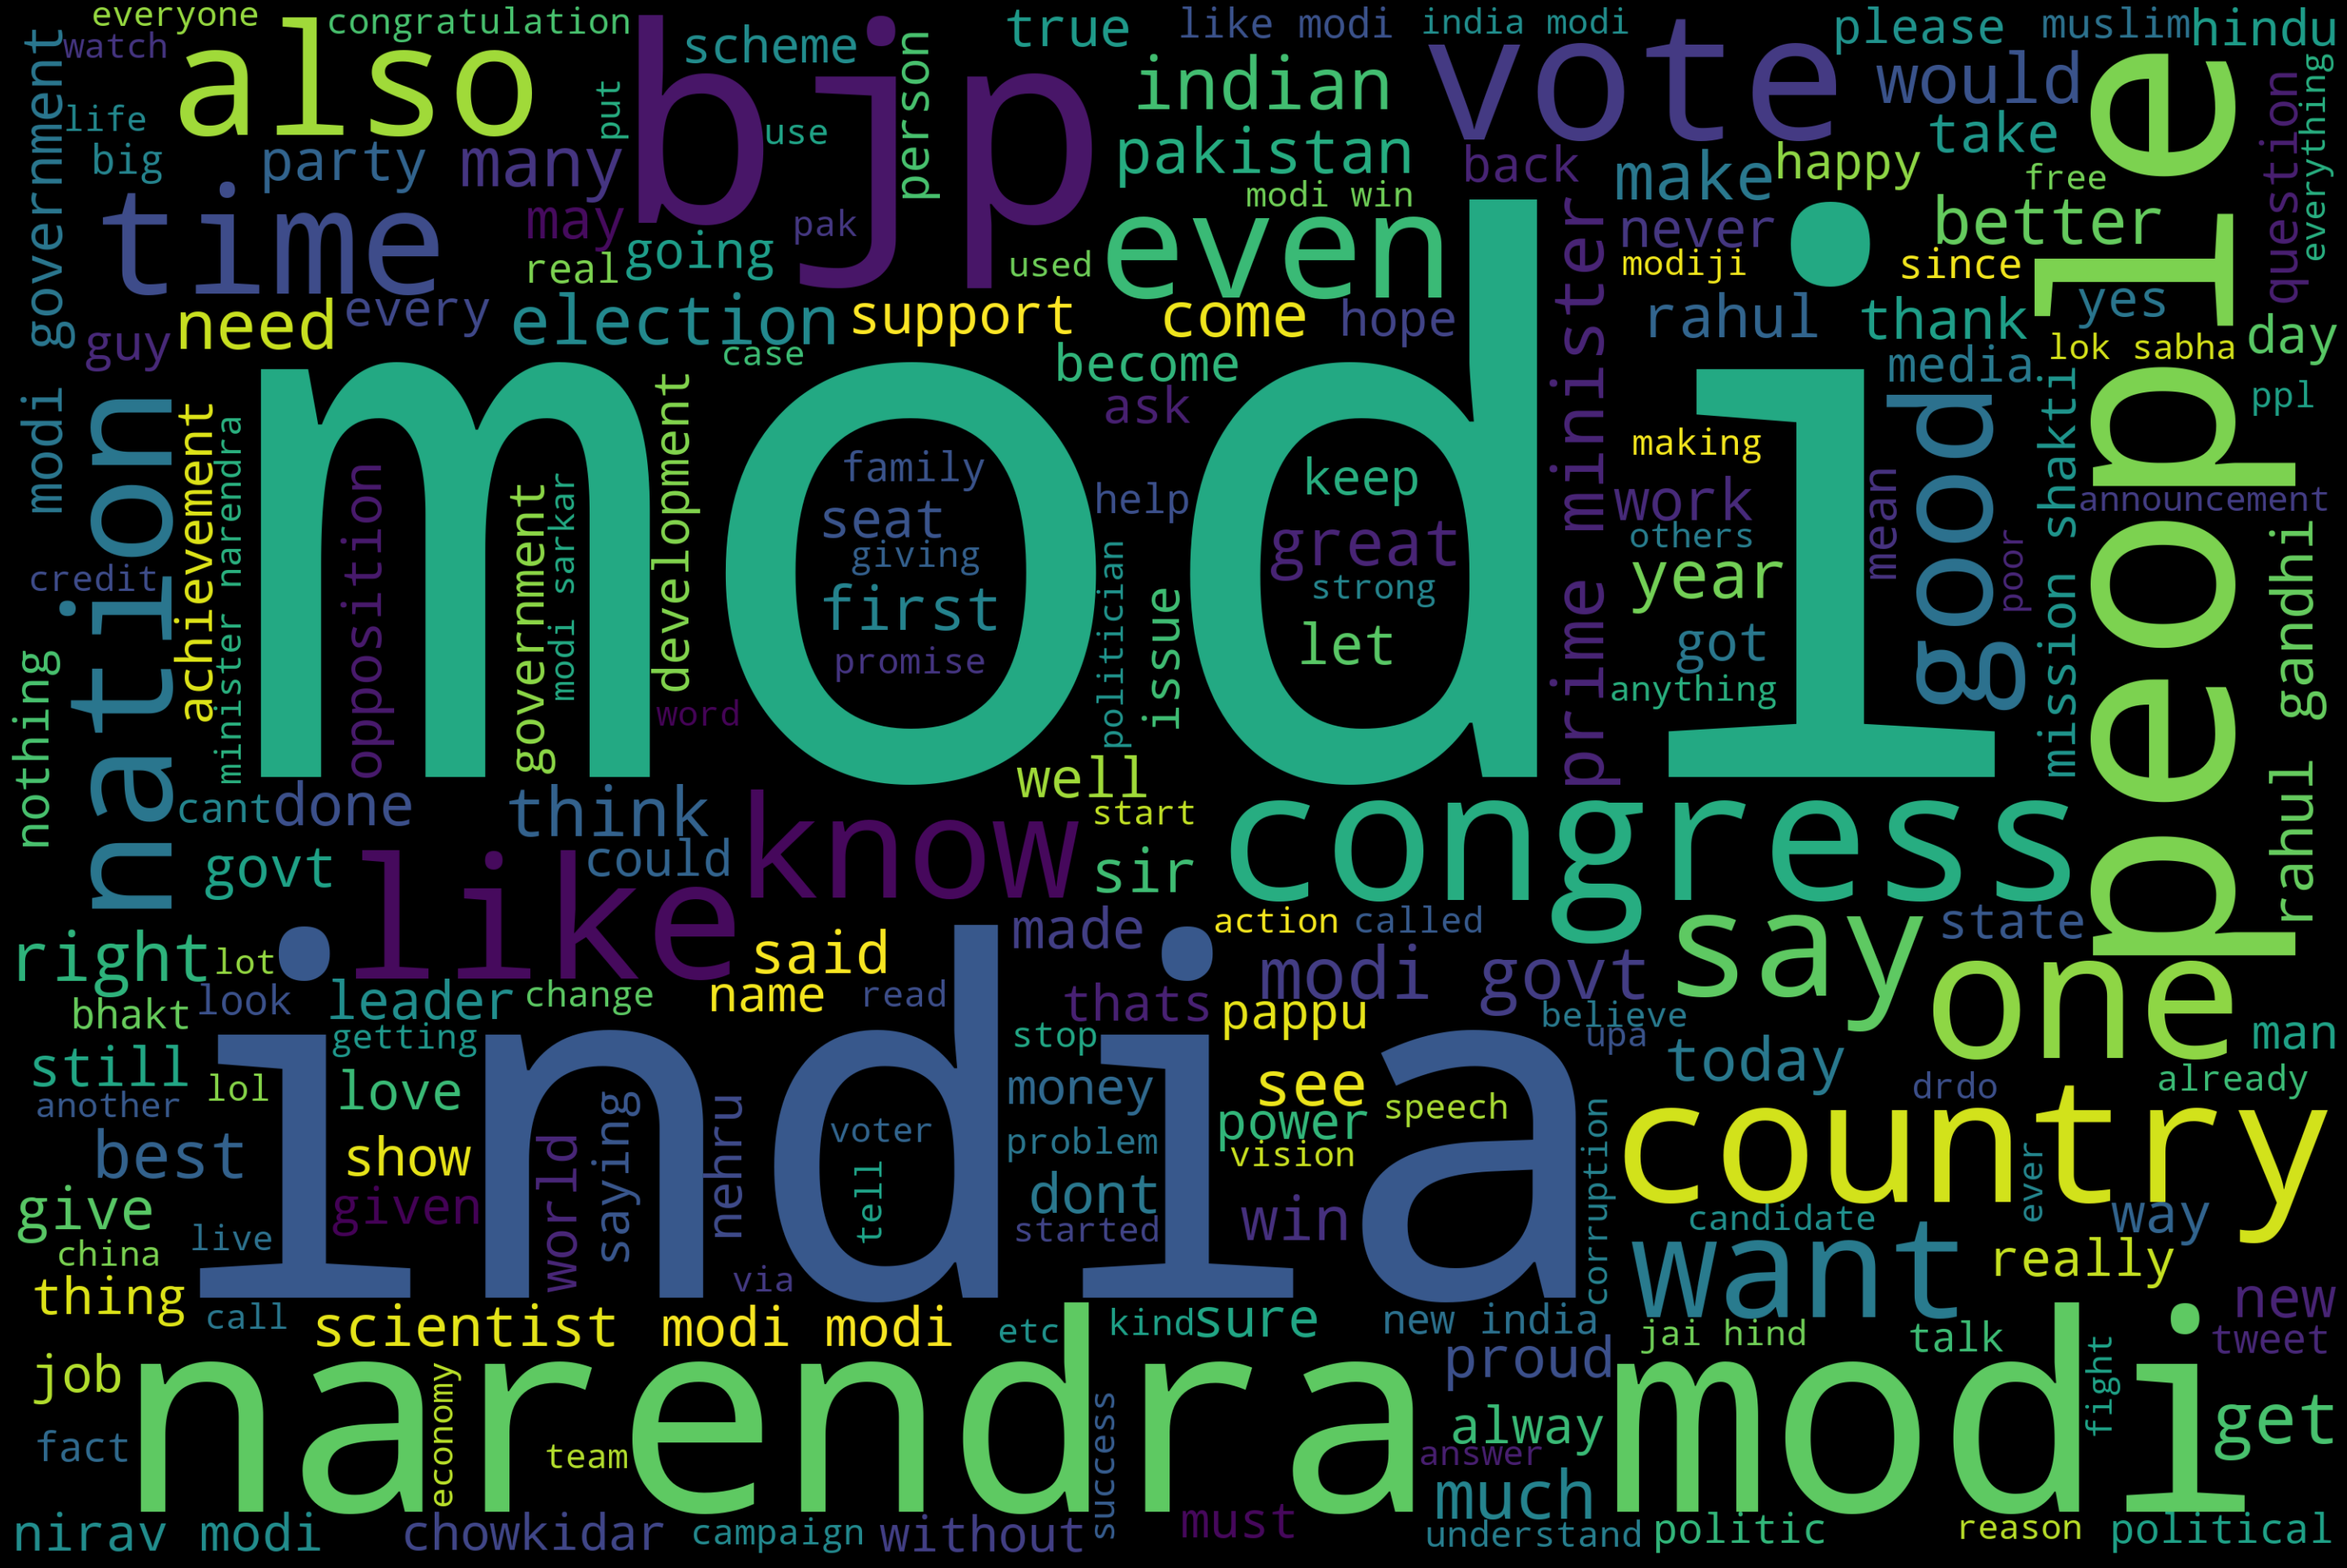

In [ ]:
# Visualizing the data using word cloud;
# positive tweets

text = ''

for tweet in df[df['category'] == 1.0]['clean_text']:
    text += f" {tweet}"
    
wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

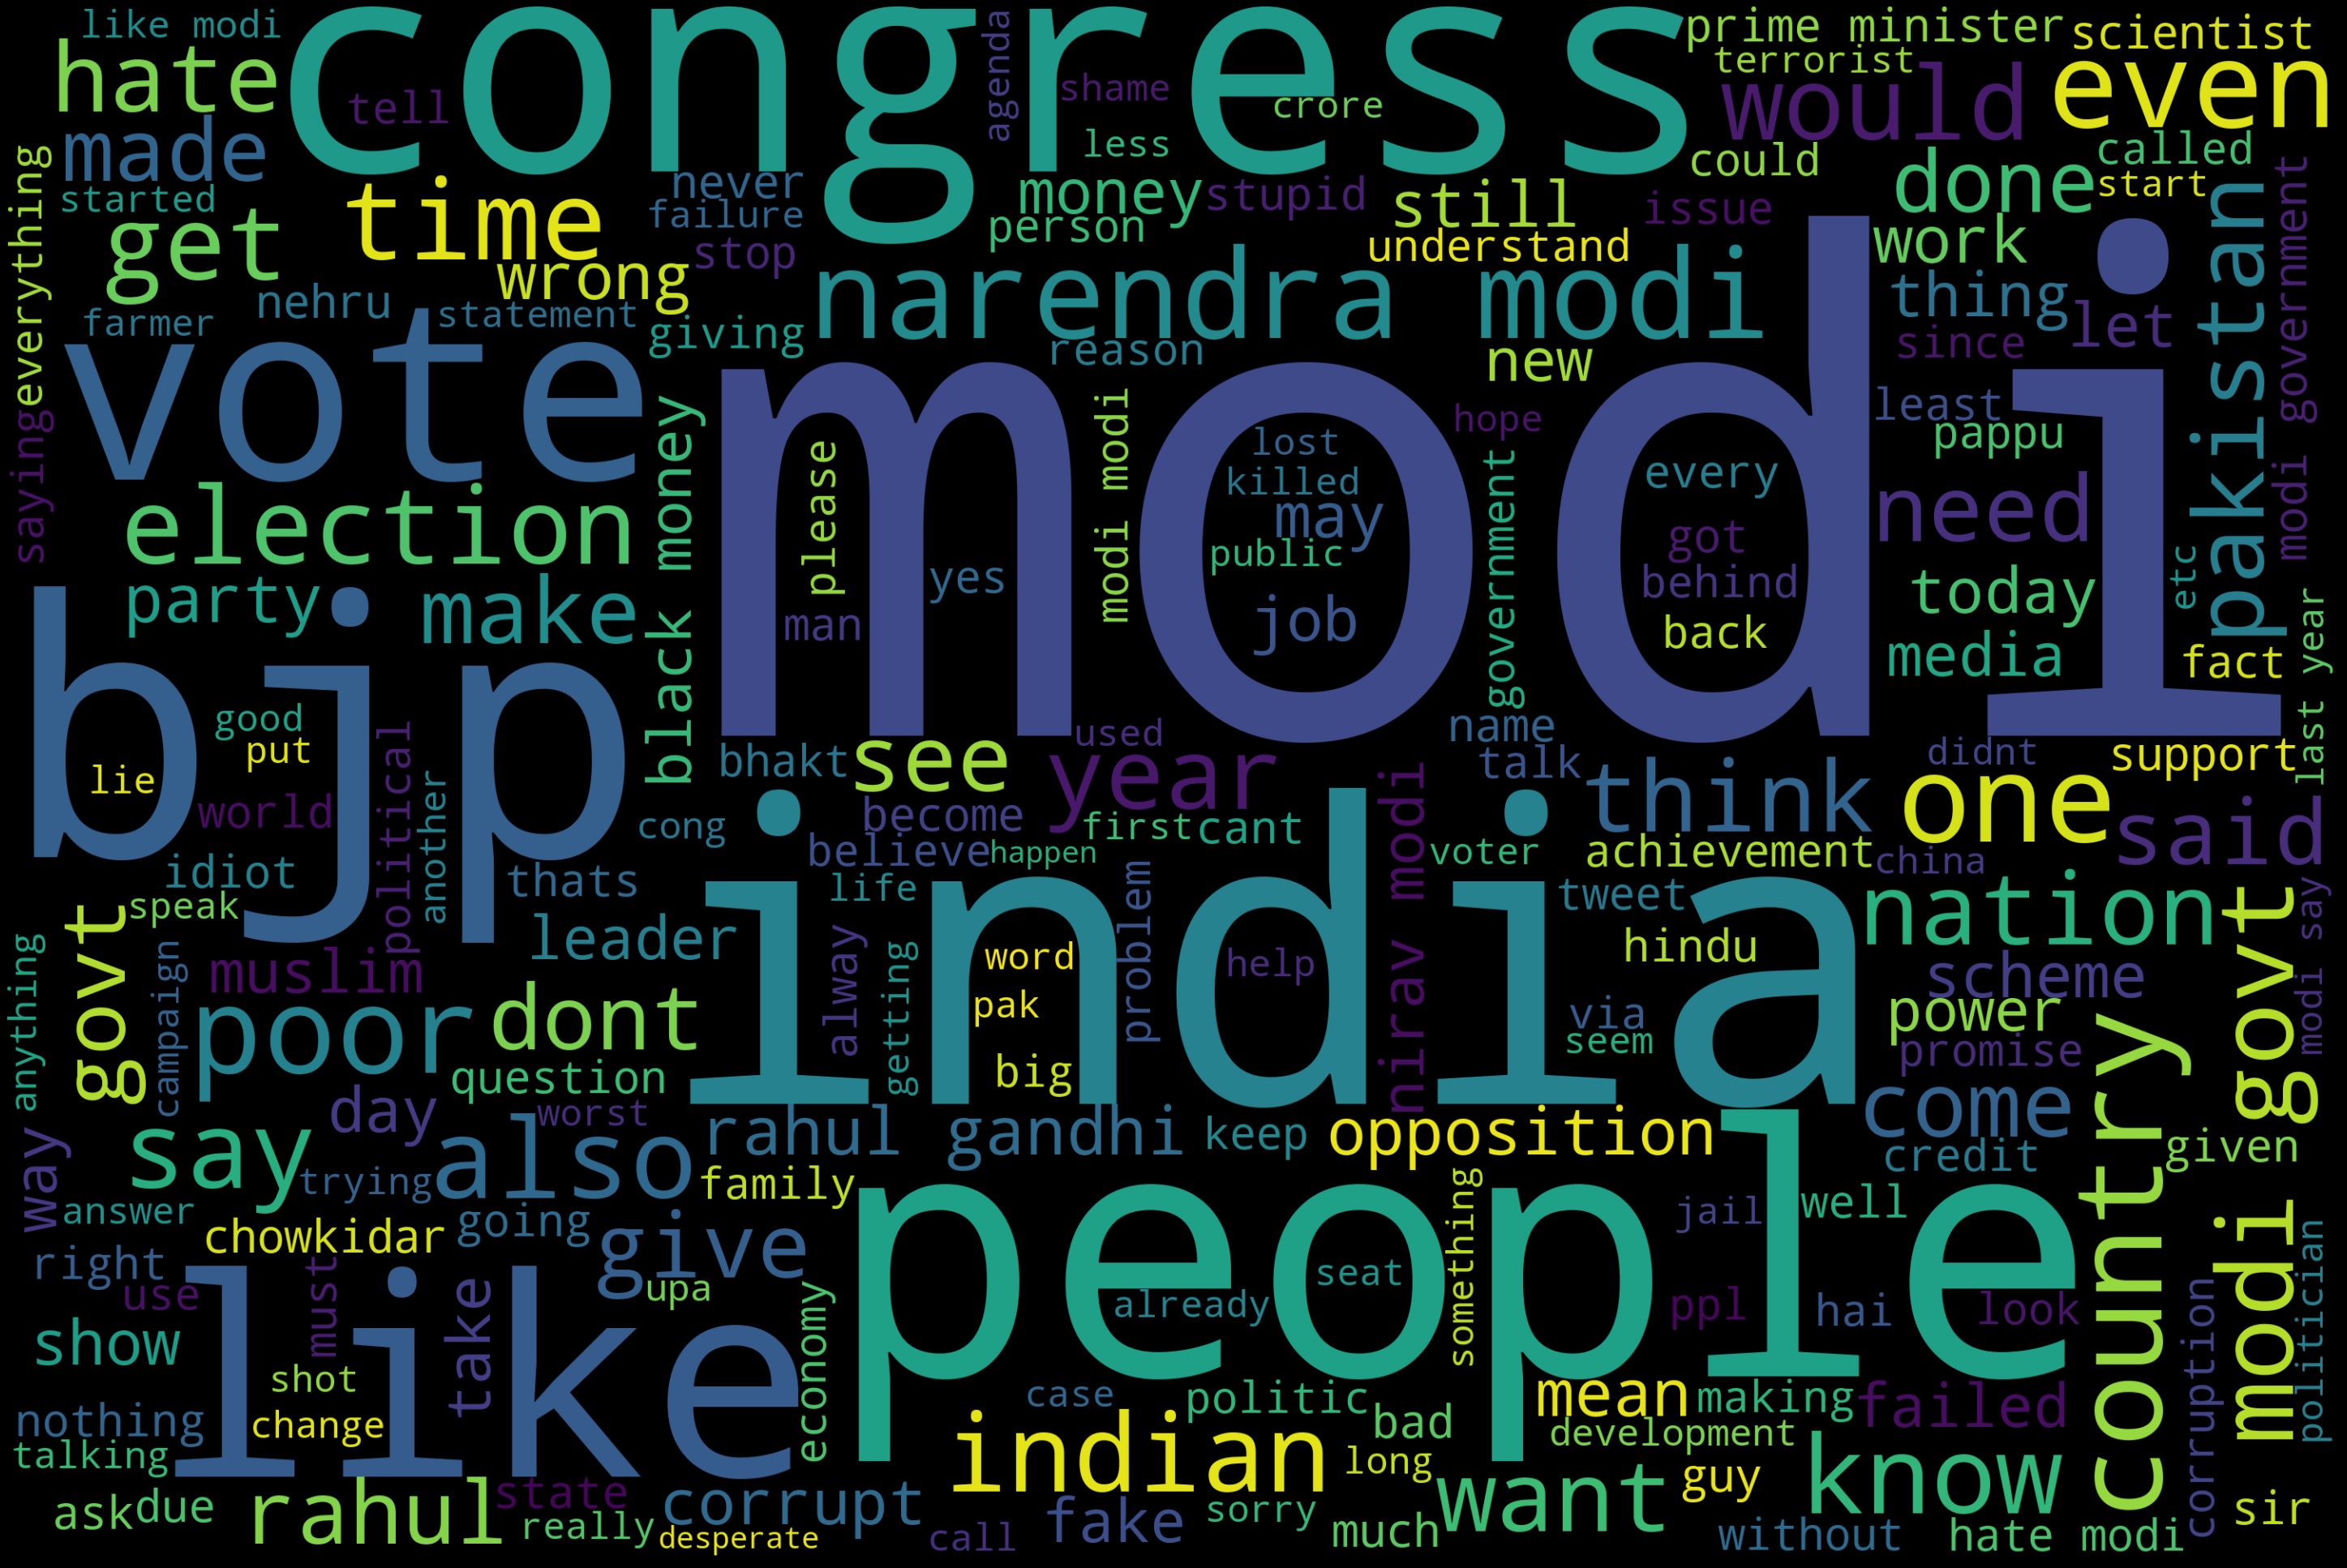

In [ ]:
# negative tweets

text = ''

for tweet in df[df['category'] == -1.0 ]['clean_text']:
    text += f" {tweet}"
    
wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

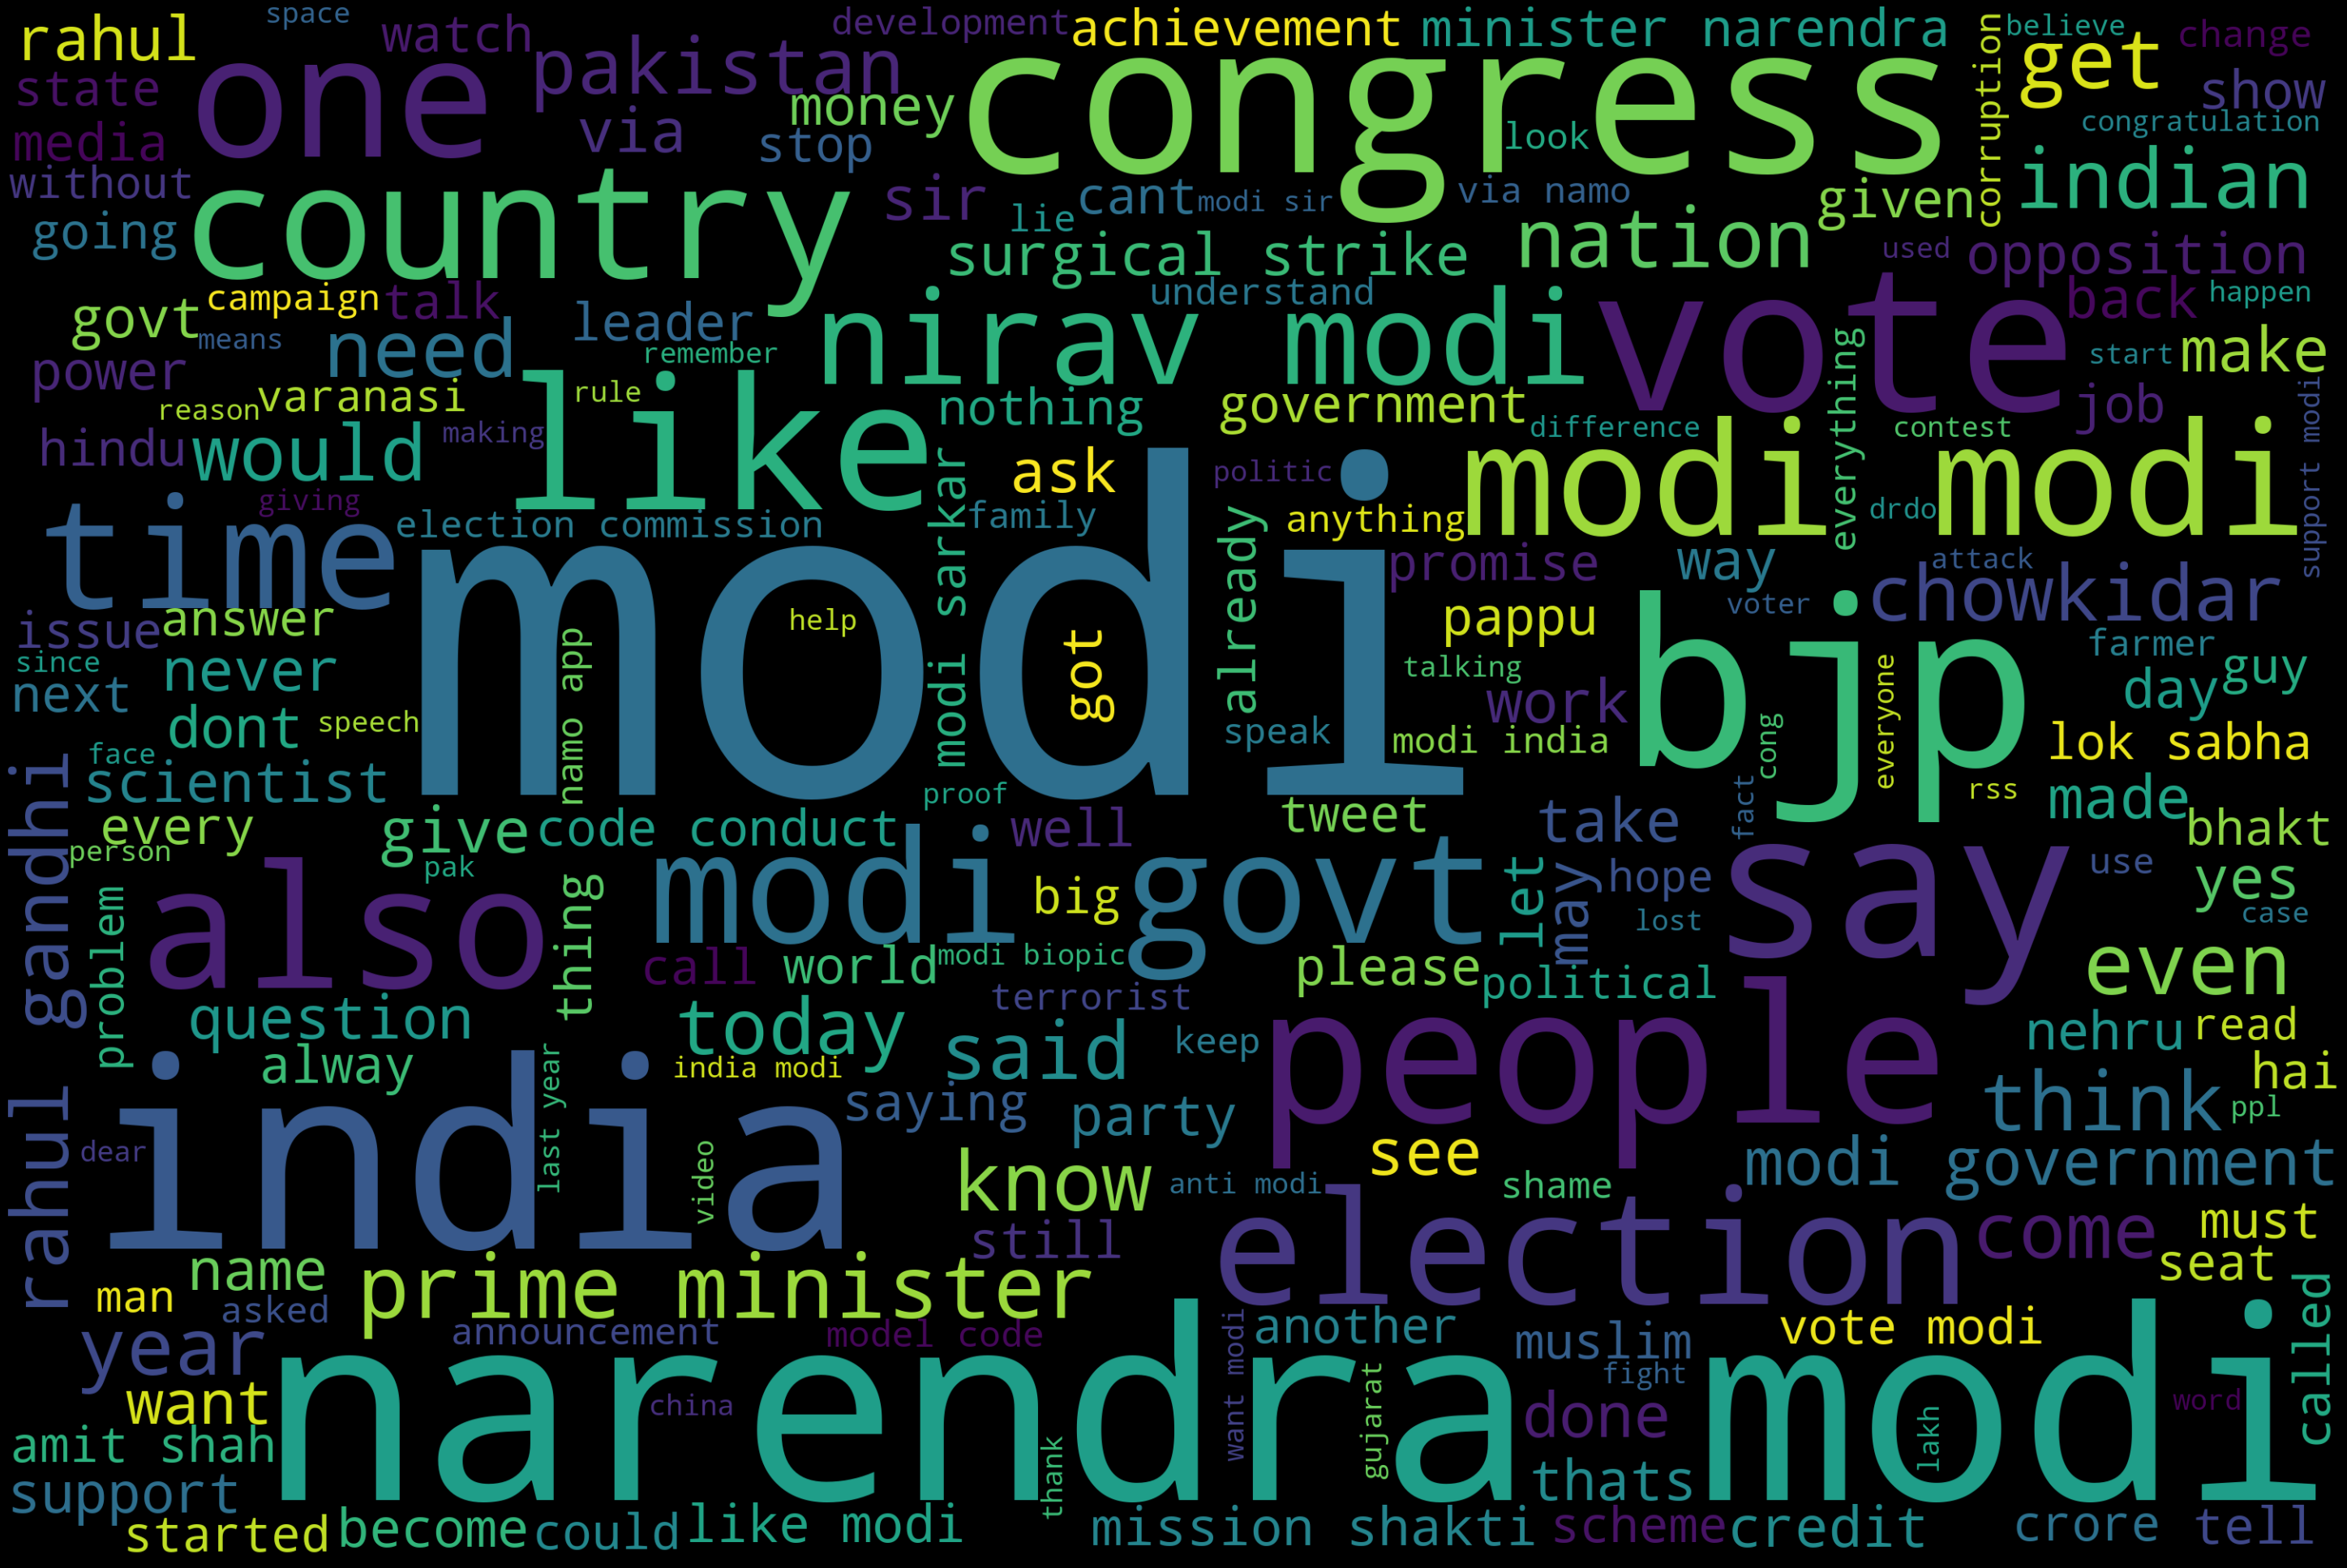

In [ ]:
# positive tweets

text = ''

for tweet in df[df['category'] == 0.0 ]['clean_text']:
    text += f" {tweet}"
    
wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

In [ ]:
# Using count vectorizer;

vec = CountVectorizer(max_features=10000)
vec.fit(df['clean_text'])

trn, val = train_test_split(df, test_size=0.3, random_state=42)

trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

In [ ]:
# Using onevsrest approach;

from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
clf.fit(trn_abs, trn['category'])

val_preds = clf.predict(val_abs)
f1_score(val['category'], val_preds, average='micro')

0.948947659078358

In [ ]:
print(clf.score(val_abs, val['category']))

0.948947659078358


In [ ]:
accuracy_score(val['category'], val_preds)

0.948947659078358

In [ ]:
confusion_matrix(val['category'], val_preds)

array([[ 9572,   264,   855],
       [  198, 16215,   231],
       [  687,   261, 20608]])

In [ ]:
print(classification_report(val['category'], val_preds))

              precision    recall  f1-score   support

        -1.0       0.92      0.90      0.91     10691
         0.0       0.97      0.97      0.97     16644
         1.0       0.95      0.96      0.95     21556

    accuracy                           0.95     48891
   macro avg       0.94      0.94      0.94     48891
weighted avg       0.95      0.95      0.95     48891



In [ ]:
# Using Tfidf Vectorizer;

vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(df['clean_text']))

trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_ = clf.fit(trn_abs, trn['category'])

val_preds = clf.predict(val_abs)
f1_score(val['category'], val_preds, average='micro')


0.9445705753615184

In [ ]:
print(clf.score(val_abs, val['category']))

0.9445705753615184


In [ ]:
# Word Embedding;

# tokenize
tok = Tokenizer(num_words = 1000000)
# fit
tok.fit_on_texts(df['clean_text'].str.lower().tolist())

vocab_size = len(tok.word_index) + 1

In [ ]:

X_trn = tok.texts_to_sequences(trn['clean_text'])
X_val = tok.texts_to_sequences(val['clean_text'])

In [ ]:
maxlen = 200
X_trn = pad_sequences(X_trn, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

In [ ]:
embedding_dim = 50
vocab_size = len(tok.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))

model.add(Flatten())
model.add(Dense(200, activation='relu', name = 'Fully_Connected'))
model.add(Dense(1, activation='sigmoid', name = 'Output'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           5683950   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
Fully_Connected (Dense)      (None, 200)               2000200   
_________________________________________________________________
Output (Dense)               (None, 1)                 201       
Total params: 7,684,351
Trainable params: 7,684,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_trn, trn['category'], validation_data=(X_val, val['category']), verbose=True, epochs=20, batch_size=256,
          callbacks = [tf.keras.callbacks.ReduceLROnPlateau()])

Epoch 1/20
446/446 [==============================] - 38s 83ms/step - loss: -5.8514 - accuracy: 0.4364 - val_loss: -164.1909 - val_accuracy: 0.5556
Epoch 2/20
446/446 [==============================] - 36s 81ms/step - loss: -476.7416 - accuracy: 0.5656 - val_loss: -1768.7823 - val_accuracy: 0.5611
Epoch 3/20
446/446 [==============================] - 35s 79ms/step - loss: -3099.6976 - accuracy: 0.5633 - val_loss: -6027.1646 - val_accuracy: 0.5453
Epoch 4/20
446/446 [==============================] - 35s 79ms/step - loss: -9061.2945 - accuracy: 0.5676 - val_loss: -13720.5234 - val_accuracy: 0.5577
Epoch 5/20
446/446 [==============================] - 35s 80ms/step - loss: -19792.6638 - accuracy: 0.5663 - val_loss: -25292.9238 - val_accuracy: 0.5461
Epoch 6/20
446/446 [==============================] - 35s 79ms/step - loss: -34984.7183 - accuracy: 0.5644 - val_loss: -41309.6289 - val_accuracy: 0.5564
Epoch 7/20
446/446 [==============================] - 35s 79ms/step - loss: -55956.0770 

In [ ]:
val_preds = model.predict(X_val)

f1_score(val['category'], val_preds, average='micro')

0.5521057045263954

In [ ]:
# Performance Metrics

accuracy_score(val['category'], val_preds)

0.5521057045263954

In [ ]:
confusion_matrix(val['category'], val_preds)

array([[    0, 10576,   115],
       [    0, 16616,    28],
       [    0, 11179, 10377]])

In [ ]:
print(classification_report(val['category'], val_preds))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00     10691
         0.0       0.43      1.00      0.60     16644
         1.0       0.99      0.48      0.65     21556

    accuracy                           0.55     48891
   macro avg       0.47      0.49      0.42     48891
weighted avg       0.58      0.55      0.49     48891

